# Readability

In [120]:
import pandas as pd
from textstat.textstat import easy_word_set
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
from collections import Counter
import re, os, csv, random
from nltk.corpus import cmudict
cmu_syllables = cmudict.dict()

## Defining some basic lexicons and measures

Textstat.easywordset (imported above) gives us a conventional list of 3,000 "easy words" that is used, for instance in the Dale-Chall readability measure.

We also need a large lexicon of 600,000 words that will include almost all English words. We'll use this below to identify proper nouns: things not in the large_lexicon, and capitalized, will be presumed to be proper nouns.

In [2]:
large_lexicon = set()

with open('../../DataMunging/rulesets/MainDictionary.txt', encoding = 'utf-8') as f:
    for line in f:
        fields = line.strip().split('\t')
        large_lexicon.add(fields[0])        

In [23]:
subtlex = dict()
with open('../frequencies/SUBTLEXus.tsv', encoding = 'utf-8') as f:
    reader = csv.DictReader(f, delimiter = '\t')
    for row in reader:
        subtlex[row['Word'].lower()] = float(row['Lg10CD'])

#### functions that count syllables

In [94]:
def syllable_count(word):
    global cmu_syllables
    
    if word in cmu_syllables:
        syll_options = [len(list(y for y in x if y[-1].isdigit())) for x in cmu_syllables[word.lower()]]
        return syll_options[0]
    else:
        count = 0
        vowels = "aeiouy"
        if word[0] in vowels:
            count += 1
        for index in range(1, len(word)):
            if word[index] in vowels and word[index - 1] not in vowels:
                count += 1
        if word.endswith("e"):
            count -= 1
        if word.endswith("le"):
            count += 1
        if count == 0:
            count += 1
        return count

def text_syllables(words):

    syllables = 0
    one_syllable_count = 0
    polysyllable_count = 0
    
    for w in words:
        if len(w) > 0:
            this_syllable = syllable_count(w)
            syllables += this_syllable
            if this_syllable < 2:
                one_syllable_count += 1
            elif this_syllable >= 3:
                polysyllable_count += 1
    
    if syllables == 0:
        syllables = 1
    if one_syllable_count == 0:
        syllables == 1
    if polysyllable_count == 0:
        polysyllable_count = 1
    
    return syllables, one_syllable_count, polysyllable_count
        
def polysyllable_count(text):
    words = text.split()
    wordcount = len(words)
    if wordcount < 1:
        return 0
    
    polysyllable = 0
    
    for w in words:
        w = w.strip('.,!?)([])-')
        syllable_count = syllables_count(w)
        if syllable_count >= 3:
            polysyllable += 1
    return polysyllable

In [95]:
for w in ['these', 'functions', 'challenge', 'our', 'hearts', 'and', 'vocabulary', 
          'solution', 'imperfect', 'but', 'I', 'accept', 'trouble', 'Zanthagle']:
    print(w, syllable_count(w))

these 1
functions 2
challenge 2
our 2
hearts 1
and 1
vocabulary 5
solution 3
imperfect 3
but 1
I 1
accept 2
trouble 2
Zanthagle 3


#### a function that counts "difficult words"

This relies heavily on the Dale-Chall "easy word" list, but refines it in ways borrowed from the Gunning "fog" index: by excluding not just easy words but relatively short words, proper nouns, and easy words + -ed or -s from our list of "difficult words."

I think this is probably the measure best suited to oral argument.

In [10]:
propernouns = Counter()
hardwords = Counter()

def difficult_word_pct(text):
    global large_lexicon, propernouns, hardwords, easy_word_set
    
    words = text.split()
    wordcount = len(words)
    if wordcount < 1:
        return 0.2
    
    difficult = 0
    
    for w in words:
        
        w = w.strip('.,!?)([])-')
        if len(w) > 0 and w[0].isupper():
            capitalized = True
        else:
            capitalized = False
        w = w.lower()
        
        if w in easy_word_set:
            continue
            
        if len(w) < 7:
            continue
        
        if w.endswith('ed'):
            if w[0 : -2] in easy_word_set:
                continue
        
        if w.endswith('s'):
            if w[0 : -1] in easy_word_set:
                continue
        
        if capitalized and w not in large_lexicon:
            w = w[0].upper() + w[1: ]
            propernouns[w] += 1
        
        if '-' in w:
            wparts = w.split('-')
            allok = True
            for wpart in wparts:
                if wpart not in easy_word_set and len(wpart) > 2:
                    allok = False
            if not allok:
                difficult += 1
                hardwords[w] += 1
        else:
            difficult += 1
            hardwords[w] += 1
        
    return difficult/wordcount

#### a function that measures mean subtlexus frequency


In [75]:
def mean_subtlex(words):
    global subtlex, large_lexicon
    
    freqs = []
    for w in words:
        if len(w) > 0 and w in subtlex:
            freqs.append(subtlex[w])
        elif len(w) > 6 and w in large_lexicon:
            freqs.append(0.3)
    
    if len(freqs) > 0:
        return np.mean(freqs)
    else:
        return 3

#### a function that divides text into sentences

This is shamelessly borrowed from Stack Overflow. It deals with a lot of edge cases pretty well.

In [13]:
# The code below is directly borrowed from Deduplicator at
# https://stackoverflow.com/questions/4576077/python-split-text-on-sentences

caps = "([A-Z])"
prefixes = "(Mr|St|Mrs|Ms|Dr)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov)"

def split_into_sentences(text):
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub(websites,"<prd>\\1",text)
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    text = re.sub("\s" + caps + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(caps + "[.]" + caps + "[.]" + caps + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(caps + "[.]" + caps + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + caps + "[.]"," \\1<prd>",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")
    sentences = text.split("<stop>")
    sentences = sentences[:-1]
    sentences = [s.strip() for s in sentences]
    return sentences

In [14]:
text = "This is a story about Mr. John Johnson, Jr., who is our hero. He laughs!  \
He sings about the F.B.I! Is it a good story? Unfortunately it's not.It ends anticlimactically."
split_into_sentences(text)

['This is a story about Mr. John Johnson, Jr., who is our hero.',
 'He laughs!',
 'He sings about the F.B.I!',
 'Is it a good story?',
 "Unfortunately it's not.",
 'It ends anticlimactically.']

In [66]:
def parse_text(text):
    sentences = split_into_sentences(text)
    sentcount = len(sentences)
    
    nonproper = []
    count = 0
    
    for s in sentences:
        words = s.split()
        for idx, w in enumerate(words):
            w = w.strip('.,!?);:([])-1234567890\"\'')
            if len(w) < 1:
                continue
            
            count += 1
            if idx > 0 and w[0].isupper():
                continue
            else:
                nonproper.append(w.lower())
    
    return sentcount, nonproper, count

## Actually computing readability measures

Our strategy is to proceed term by term, using the files previously produced by build_term_datasets.ipynb. Each row here represents everything said by one justice about one case.

In each term we iterate through the rows. We ignore extremely short rows with 1 or 2 words. But otherwise we calculate a bunch of metrics for the row and add them to lists. When we're done with a term, we take the *median* for each metric's list, and consider that the yearly value.

The formulas I'm using for each metric are, at the moment, drawn directly from
https://en.wikipedia.org/wiki/Readability#The_Gunning_fog_formula

For a publishable version I would trace back to the original publications.

In [112]:
terms = []
fog_vals = []
diff_vals = []
sl_vals = []
smog_vals = []
wordlen_vals = []
flesch_vals = []
dalechall_vals = []
syllable_vals = []
threesyll_vals = []
subtlex_vals = []

all_frames = []

for term in range(1955, 2015):
    if term == 1981:
        continue
        
    print(term)
    infile = '/Volumes/TARDIS/oralarg/termgrouped/term' + str(term) + '.tsv'
    if not os.path.isfile(infile):
        continue
    else:
        data = pd.read_csv(infile, sep = '\t')
    
    fog = []
    diffpcts = []
    sl = []
    
    counts_used = []
    cases_used = []
    justices_used = []
    terms_used = []
    speakercases = []
    smogs = []
    wordlens = []
    flesches = []
    dalechalls = []
    syllablesperword = []
    threesyllables = []
    subtlexes = []
    weights = []
    sentence_counts = []
    
    ctr = 0
    for idx, row in data.iterrows():
        text = row['text']
        count = row['wordct']
        speakercase = row['speakercase']
        justice = row['justice']
        case = '-'.join(speakercase.split('-')[0:-1])
        
        
        if count < 3:
            continue
        else:
            counts_used.append(count)
            justices_used.append(justice)
            terms_used.append(term)
            cases_used.append(case)
            speakercases.append(speakercase)
                  
        sentcount, nonproper, count = parse_text(text)
        # notice that we replace previous "count" with this more accurate one
        if count == 0:
            count = 1
        weights.append(count)
        sentence_counts.append(sentcount)
        
        nonpropercount = len(nonproper) + 1
        # this needs to be used as denominator for syllables
        
        syllablecount, one_syllable_words, three_or_more_syllables = text_syllables(nonproper)
            
        avg_sent_length = count / (sentcount + 0.01)
        sl.append(avg_sent_length)
        
        one_syll_pct = (one_syllable_words / nonpropercount) * 100
        flesch = (1.599 * one_syll_pct)  - (1.015 * avg_sent_length) - 31.57
        flesches.append(flesch)
        
        diffpct = difficult_word_pct(text) * 100
        diffpcts.append(diffpct)
        
        thisfog = 0.4 * (avg_sent_length + diffpct)
        fog.append(thisfog)
        
        #poly_syllab = polysyllable_count(text)
        # SMOG = (1.043 * (30*(poly_syllab / sentcount))**0.5)  + 3.1291
        #smogs.append(SMOG)
        
        wordlenlist = [len(x.strip('.,()[]!?')) for x in text.split()]
        wordlens.append(np.mean(wordlenlist))
        
        dalechall = (0.1579 * diffpct) + (0.0496 * avg_sent_length) + 3.6365
        dalechalls.append(dalechall)
        
        syllablesperword.append(syllablecount / nonpropercount)
        
        threesyllables.append(three_or_more_syllables / nonpropercount)
        
        subtlexes.append(mean_subtlex(nonproper))
        
    
    # flesch_vals.append(np.mean(flesch))
    diffmedian = np.average(diffpcts, weights = weights)
    diff_vals.append(diffmedian)
    
    fogavg = np.average(fog, weights = weights)
    fog_vals.append(fogavg)
    smogmedian = np.median(smogs)
    smog_vals.append(smogmedian)
    wordlength = np.average(wordlens, weights = weights)
    wordlen_vals.append(wordlength)
    sl_vals.append(np.average(sl, weights = sentence_counts)) 
    flesch_vals.append(np.average(flesches, weights = weights))
    dalechall_vals.append(np.average(dalechalls, weights = weights))
    syllable_vals.append(np.average(syllablesperword, weights = weights))
    threesyll_vals.append(np.average(threesyllables, weights = weights))
    subtlex_vals.append(np.average(subtlexes, weights = weights))
    
    # smog_vals.append(np.median(smogs))
    
    terms.append(term)
    
    df = pd.DataFrame({'case': cases_used, 'justice': justices_used, 'speakercase': speakercases, 
                    'difficultpct': diffpcts, 'sentlength': sl, 'fog': fog, 'term': terms_used,
                      'flesch': flesches, 'dalechall': dalechalls, 'subtlex': subtlexes, 'wordcount': weights})
    all_frames.append(df)

1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014


/Users/tunder/miniconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/tunder/miniconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### average word length

Higher lengths are more difficult. Note that this is a pretty bad measure, because most words are short, so this gets dominated by difference between "a" and "these," neither of which are in reality hard words.

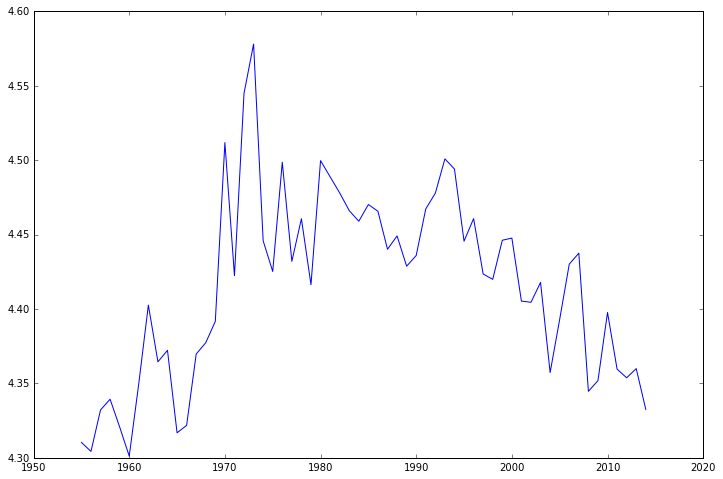

In [97]:
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(terms, wordlen_vals)
plt.show()

### percentage of difficult words

This is a better measure, which focuses attention at the high end of the lexicon where things actually get hard. Notice also that it does *generally* track the pattern of "word length." There's a decline from the early 70s to the present.

This is probably the measure I trust most.

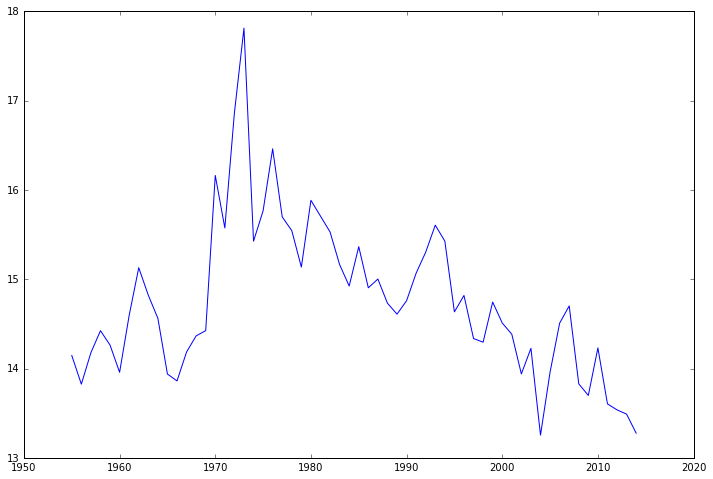

In [78]:
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(terms, diff_vals)
plt.savefig('percentdifficultwords.png')
plt.show()

### fraction of words three syllables or more

Proper nouns are not considered in our syllable counting, which could be one reason for a slightly different curve.

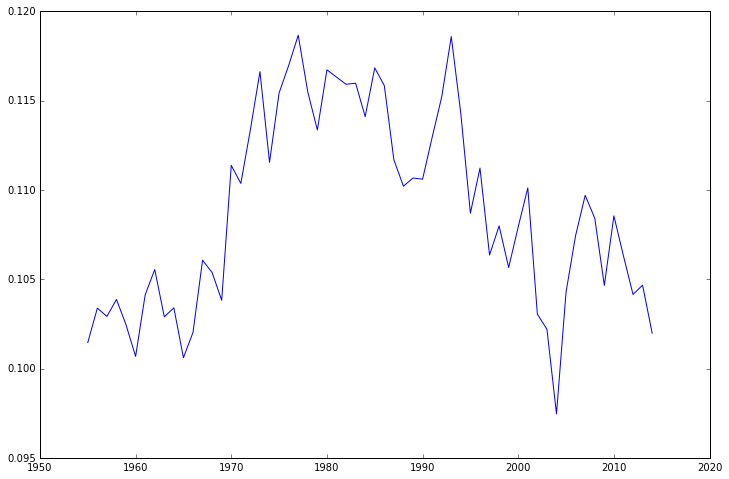

In [98]:
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(terms, threesyll_vals)
plt.show()

### mean subtlexus frequency

Note that higher values are more frequent (easier) words, so I have flipped the y axis to make this visually congruent to other scales. Proper nouns are also not counted here, which could be one reason why it echoes the three-syllable curve.

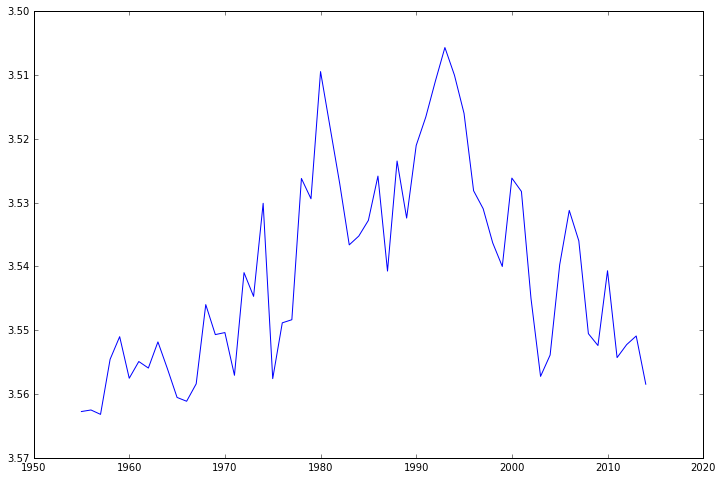

In [99]:
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(terms, subtlex_vals)
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
plt.show()

### average sentence length

There are lots of reasons not to trust this. In a transcription, sentence length is probably controlled more by the transcriber's punctuation choices than by the speaker; you see what I mean?

But here it is. The abrupt and dramatic shifts here look to me suspiciously like different transcribers. But fwiw, if it were real, the decline from 70s to early 2000s would echo the decline seen above.

There's a return to long sentences at the end, though.

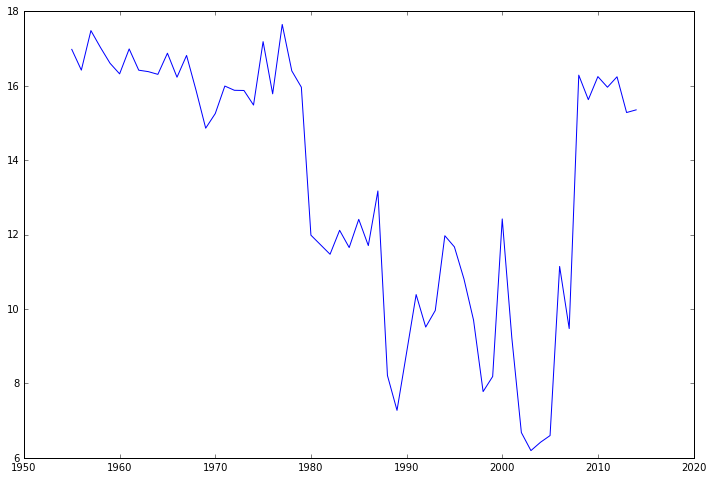

In [89]:
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(terms, sl_vals)
plt.show()

### fog index

There are lots and lots of ways to combine sentence length with measures of diction difficulty. The Gunning fog index is one. I'm not sure I've calculated it strictly correctly; I think I should use syllable count rather than the Dale-Chall list to define "difficult words." But this is 

    0.4 * (avg_sentence_length + pct_difficult_words)


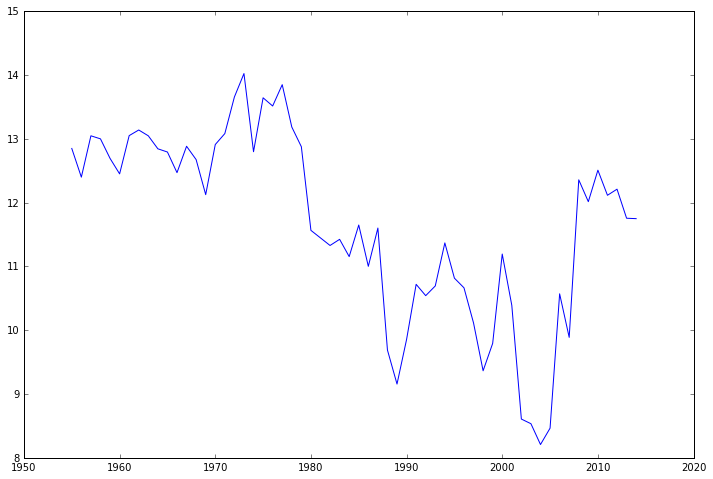

In [113]:
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(terms, fog_vals)
plt.show()

### Dale-Chall

The Dale-Chall formula is one of the best of the readability metrics; it correlates at 0.93 with comprehension as measured on reading tests. And it broadly fits the "difficult words" trajectory, with just a slight uptick in the last ten years. It is:

    (0.1579 * pct_difficult_words) + (0.0496 * avg_sentence_length) + 3.6365

The values here probably underestimate the grade level because I exclude more categories from "difficult words" than Dale & Chall did.

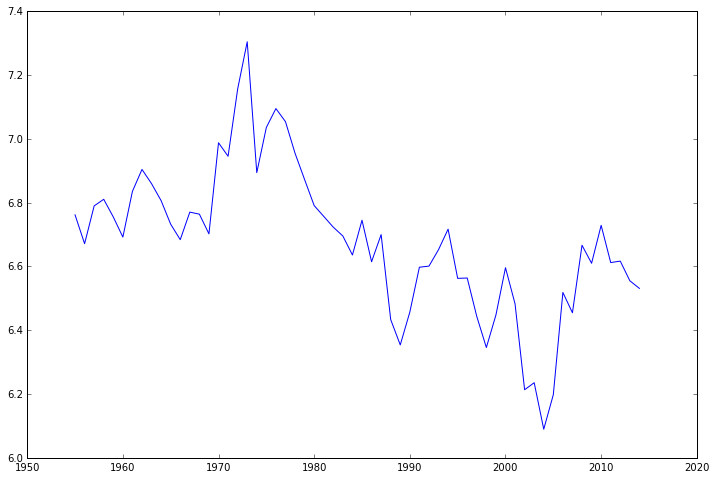

In [91]:
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(terms, dalechall_vals)
plt.show()

### Flesch-Kincaid readability

One of the oldest metrics, but I'm using a later adjusted formula

    (1.599 * pct_one_syllable_words) − (1.015 * average_sentence_length) − 31.517
   
On this scale higher values are *more* readable. That's the reverse of everything above, so I've flipped the y axis to keep things congruent and immediately intepretable.

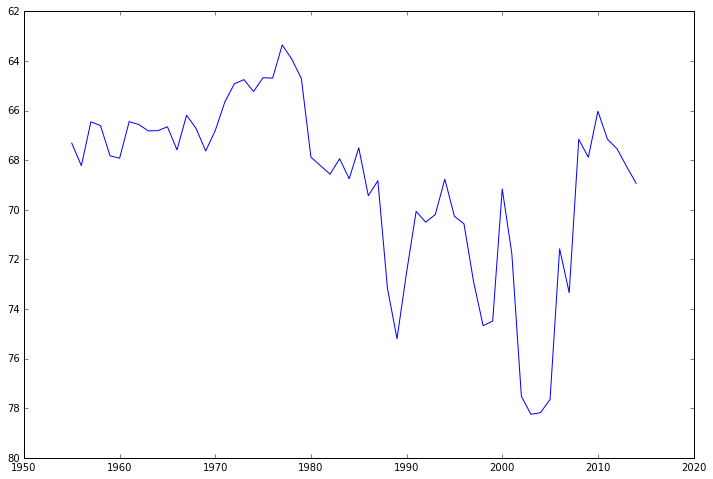

In [100]:
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(terms, flesch_vals)
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
plt.show()

## Producing data and writing to file

In [114]:
readability = pd.concat(all_frames, ignore_index = True)
readability.shape

(39868, 11)

In [115]:
readability.to_csv('../results/readability.tsv', sep = '\t', index = False)

In [116]:
justices = []
terms = []
meandiff = []

by_justice = readability.groupby(['justice', 'term'])
for justterm, df in by_justice:
    mean_difficulty = np.average(df.difficultpct, weights = df.wordcount)
    justice, term = justterm
    justices.append(justice)
    terms.append(term)
    meandiff.append(mean_difficulty)
    
df = pd.DataFrame({'justice': justices, 'term': terms, 'meandiff': meandiff})

In [117]:
df.to_csv('../results/difficulty_by_justice_and_term.tsv', sep = '\t', index = False)

In [118]:
cases = []
meandiff = []

by_cases = readability.groupby('case')
for case, df in by_cases:
    mean_difficulty = np.average(df.difficultpct, weights = df.wordcount)
    cases.append(case)
    meandiff.append(mean_difficulty)

df = pd.DataFrame({'case': cases, 'meandiff': meandiff})
df.to_csv('../results/difficulty_by_case.tsv', sep = '\t', index = False)

In [146]:
hardest = hardwords.most_common(10000)

In [149]:
with open('hardwords.txt', mode = 'w',encoding = 'utf-8') as f:
    for word in hardest:
        f.write(word[0] + '\n')

In [150]:
properest = propernouns.most_common(10000)

In [151]:
with open('propernouns.txt', mode = 'w',encoding = 'utf-8') as f:
    for word in properest:
        f.write(word[0] + '\n')

In [119]:
by_justice = readability.groupby('justice')
for justice, df in by_justice:
    mean_difficulty = np.average(df.difficultpct, weights = df.wordcount)
    print(justice, mean_difficulty)

AFortas 15.3595004946
AJGoldberg 23.9074242012
AMKennedy 15.5257285341
AScalia 14.2354648779
BRWhite 13.960094964
CEWhittaker 15.9000111545
CThomas 16.2967685064
DHSouter 14.8795042481
EKagan 14.1247506611
EWarren 12.8859030248
FFrankfurter 14.8399365469
HABlackmun 15.0201580984
HHBurton 13.4343821212
HLBlack 12.5697999946
JGRoberts 14.9451892637
JHarlan2 16.2919411899
JPStevens 14.840142665
LFPowell 16.5331101236
PStewart 15.4395664222
RBGinsburg 14.3998633692
SAAlito 15.6888591574
SDOConnor 16.6871164553
SFReed 13.666360103
SGBreyer 11.5928835744
SMinton 13.1658856511
SSotomayor 14.9406652515
TCClark 14.3706358884
WEBurger 15.9961588301
WHRehnquist 16.6611963269
WJBrennan 15.42334321
WODouglas 14.6445377689


In [123]:
highs = []
lows = []
means = []
terms = []

for term in set(readability.term):
    print(term)
    df = readability.loc[readability.term == term, : ]
    df.reset_index(inplace = True)
    themean = np.average(df.difficultpct, weights = df.wordcount)
    trials = []
    datalen = df.shape[0]
    for i in range(1000):
        indexes = [random.choice(range(datalen)) for x in range(datalen)]
        values = df.loc[indexes, 'difficultpct']
        weights = df.loc[indexes, 'wordcount']
        thistrial = np.average(values, weights = weights)
        trials.append(thistrial)
    high, low = np.percentile(trials, [5, 95])
    
    highs.append(high)
    lows.append(low)
    means.append(themean)
    terms.append(term)

1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014


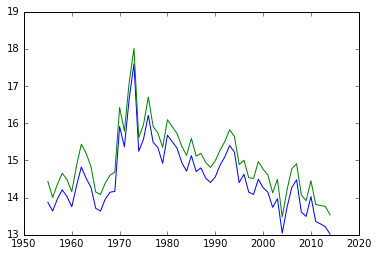

In [124]:
plt.plot(terms, highs)
plt.plot(terms, lows)
plt.show()

In [125]:
df = pd.DataFrame({'term': terms, 'hi': lows, 'lo': highs, 'mean': means})
# I think I got low and high mixed up; just flipping them here
df.to_csv('../results/pct_difficult_uncertainty.tsv', sep = '\t', index = False)